# Imports

In [10]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import pickle
from multiprocessing import Pool

import modeling
import helpers
import plotting
import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science','ieee','no-latex'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [58]:
with open('data.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    all_data = data_dict['data']
    meta_data = data_dict['meta_data']

best_params_all_backward = np.load('fitting_results/backward_params.npy')
best_params_all_backward_no_meta = np.load('fitting_results/backward_no_meta_params.npy')

# Parameter recovery

## V1-V1, Cluster 0, backward meta-learning model

In [61]:
this_model = 'option_model'
structure = 'backward'
meta_learning = True
cluster = 0
condition = 'All'
fitted_params = best_params_all_backward[(meta_data['Cluster']==cluster) & (meta_data['Condition']=='V1-V1')]
num_subject = fitted_params.shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
concentration_bounds = [-2, 1]
epsilon_bounds = [1e-6, 0.99]
bounds = [alpha_bounds, concentration_bounds, epsilon_bounds] 
param_names = ["alpha_2", 'concentration_2', 'epsilon']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

all_sim_data = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        alpha_2, concentration_2, epsilon, _ = fitted_params[i]
        inputs.append((this_model, i, 1, alpha_2, concentration_2, epsilon, condition, structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data = helpers.concatenate_data(this_data, all_sim_data)
        D = helpers.get_model_fit_data(this_data, num_block=6)  
        inputs.append((this_model, D, structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save(f'fitting_results/paramrec_{structure}_{condition}_cluster{cluster}_params.npy', best_params_all)
np.save(f'fitting_results/paramrec_{structure}_{condition}_cluster{cluster}_llh.npy', best_llh_all)

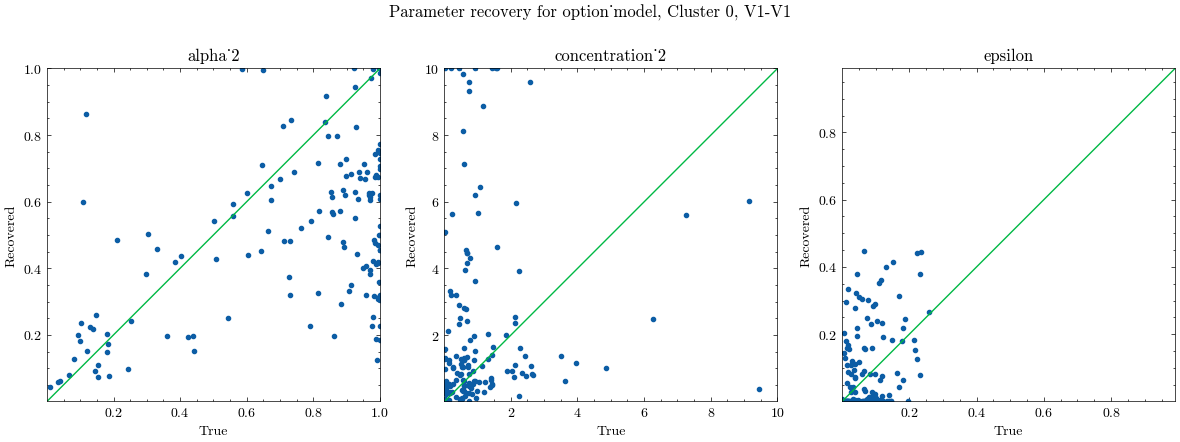

In [62]:
plt.figure(figsize=(9,9))
for p in range(len(bounds)):
    for q in range(len(bounds)):
        ax = plt.subplot(len(bounds), len(bounds), p*len(bounds)+q+1)
        p_bounds = bounds[p].copy()
        q_bounds = bounds[q].copy()

        values_p = fitted_params[:,p]
        values_q = best_params_all[:,q]
        if 'concentration' in param_names[p]:
            p_bounds[0] = 10**p_bounds[0]
            p_bounds[1] = 10**p_bounds[1]
            values_p = 10**values_p
        if 'concentration' in param_names[q]:
            q_bounds[0] = 10**q_bounds[0]
            q_bounds[1] = 10**q_bounds[1]
            values_q = 10**values_q
        plt.plot(values_p, values_q, '.')
        plt.plot([p_bounds[0],p_bounds[1]], [q_bounds[0], q_bounds[1]])
        plt.xlim(p_bounds)
        plt.ylim(q_bounds)
        plt.xlabel(f'True {param_names[p]}')
        plt.ylabel(f'Recovered {param_names[q]}')
        ax.set_box_aspect(1)

plt.suptitle(f'Parameter recovery for {this_model}, Cluster {cluster}, {experiment}')
plt.tight_layout()
plt.show()

## Blocks 1-6, Cluster 0, backward no meta-learning model

In [96]:
this_model = 'option_model'
structure = 'backward'
meta_learning = False
cluster = 0
condition = 'All'
fitted_params = best_params_all_backward_no_meta[(meta_data['Cluster']==cluster)]
num_subject = fitted_params.shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
concentration_bounds = [-2, 1]
epsilon_bounds = [1e-6, 0.99]
bounds = [alpha_bounds, concentration_bounds] 
param_names = ["alpha_2", 'concentration_2']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

all_sim_data = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        alpha_2, concentration_2, epsilon, _ = fitted_params[i]
        inputs.append((this_model, i, 1, alpha_2, concentration_2, condition, structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data = helpers.concatenate_data(this_data, all_sim_data)
        D = helpers.get_model_fit_data(this_data, num_block=6)  
        inputs.append((this_model, D, structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save(f'fitting_results/paramrec_{structure}_no_meta_{condition}_cluster{cluster}_params.npy', best_params_all)
np.save(f'fitting_results/paramrec_{structure}_no_meta_{condition}_cluster{cluster}_llh.npy', best_llh_all)


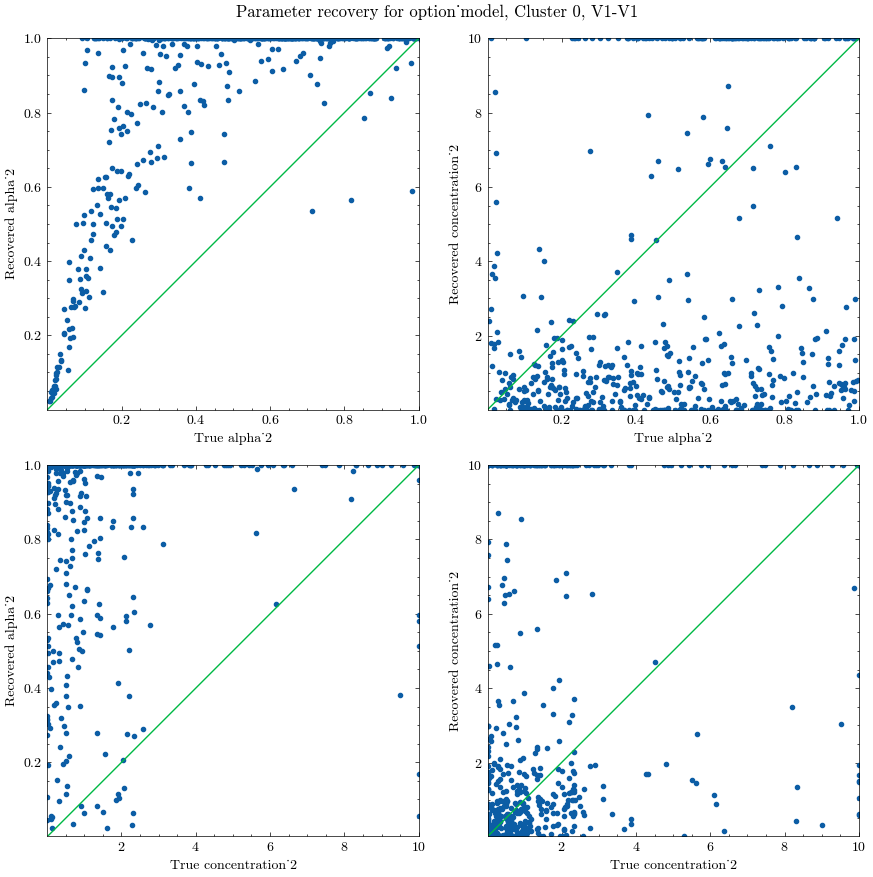

In [97]:
plt.figure(figsize=(9,9))
for p in range(len(bounds)):
    for q in range(len(bounds)):
        ax = plt.subplot(len(bounds), len(bounds), p*len(bounds)+q+1)
        p_bounds = bounds[p].copy()
        q_bounds = bounds[q].copy()

        values_p = fitted_params[:,p]
        values_q = best_params_all[:,q]
        if 'concentration' in param_names[p]:
            p_bounds[0] = 10**p_bounds[0]
            p_bounds[1] = 10**p_bounds[1]
            values_p = 10**values_p
        if 'concentration' in param_names[q]:
            q_bounds[0] = 10**q_bounds[0]
            q_bounds[1] = 10**q_bounds[1]
            values_q = 10**values_q
        plt.plot(values_p, values_q, '.')
        plt.plot([p_bounds[0],p_bounds[1]], [q_bounds[0], q_bounds[1]])
        plt.xlim(p_bounds)
        plt.ylim(q_bounds)
        plt.xlabel(f'True {param_names[p]}')
        plt.ylabel(f'Recovered {param_names[q]}')
        ax.set_box_aspect(1)

plt.suptitle(f'Parameter recovery for {this_model}, Cluster {cluster}, {experiment}')
plt.tight_layout()
plt.show()

# Likelihood landscape

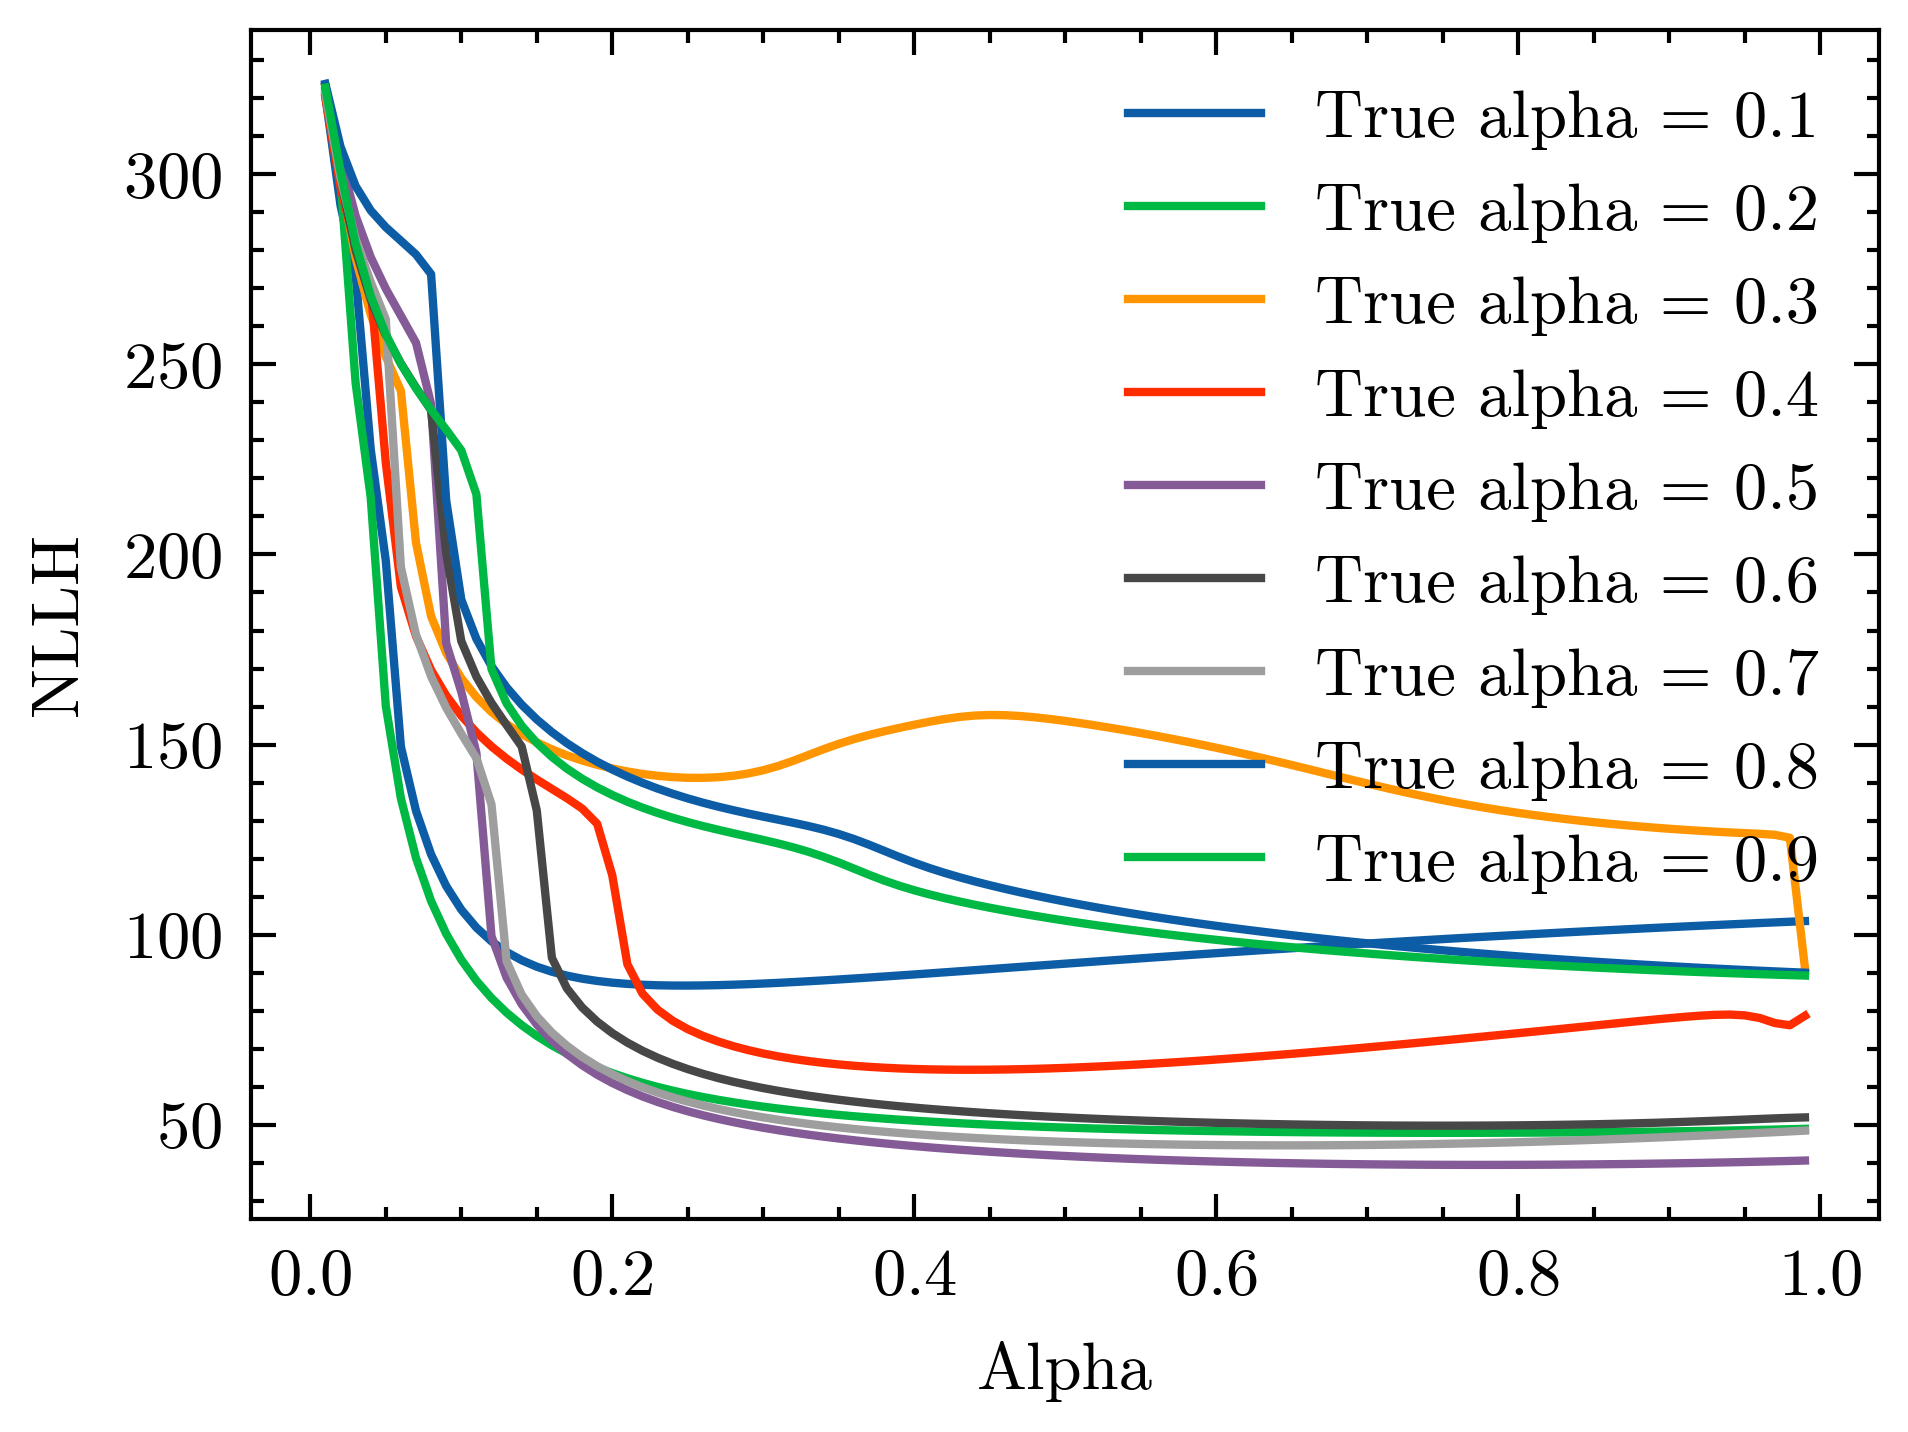

In [77]:
this_model = 'option_model'
structure = 'backward'
meta_learning = False
cluster = 0
condition = 'All'

llhs = []
true_alphas = np.arange(0.1,1,0.1)
alphas_eval = np.arange(0.01,1,0.01)
llhs = np.zeros_like(alphas_eval)
beta = 5
concentration_2 = -1
epsilon = 0.1
prior = 0

for alpha in true_alphas:
    this_data = modeling.option_model(1, alpha, concentration_2, 'All', structure, meta_learning)
    D = helpers.get_model_fit_data(this_data, num_block=6)
    for i in range(len(alphas_eval)):
        alpha_2 = alphas_eval[i]
        params = alpha_2, concentration_2
        llhs[i] = modeling.option_model_nllh(params, D, structure, meta_learning)

    plt.plot(alphas_eval, llhs, label=f'True alpha = {alpha:.1f}')

plt.xlabel('Alpha')
plt.ylabel('NLLH')
plt.legend()
plt.show()